In [87]:
import gaussian_mixture_anomaly_detection as ad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from importlib import reload
import pandas as pd
import numpy as np
import utils
import models
import ewma

reload(ad)
reload(utils)
reload(models)
reload(ewma)
%matplotlib inline

In [2]:
eff_train = utils.read_ts('data/eff_train/eff_train1.csv')
eff_train = utils.bad_to_mean(eff_train)
eff_train.head()

/Users/sergmiller/Documents/code/python/sibur/GlobalChangersSibur/utils.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[' value'][df[' quality'] != 'Good'] = mean_good


,tag,timestamp,value,quality
0,Efficiency,01.10.2016 0:00,16137.70,Good
1,Efficiency,01.10.2016 0:00,16060.55,Good
2,Efficiency,01.10.2016 0:00,16633.79,Good
3,Efficiency,01.10.2016 0:00,17578.13,Good
4,Efficiency,01.10.2016 0:00,17331.05,Good


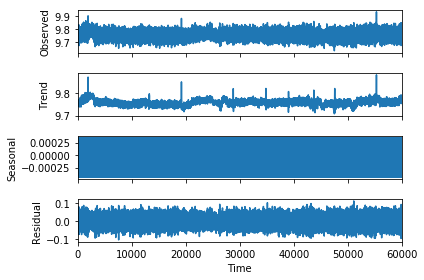

6000


,trend,season,diff
30,9.763258,-0.000435,0.000724
31,9.753591,-0.000168,-0.002821
32,9.745749,0.000001,0.001151
33,9.754862,0.000203,0.001026


In [3]:
origin_ts = eff_train[' value'][40000:100000].values
# plt.plot(range(len(origin_ts)), origin_ts)
lag_to_drop=10
df = utils.get_expanded_features(origin_ts,lag_to_drop=10,plot=True)
dropped_origin = utils.get_dropped(origin_ts, lag=10)
print(len(df))
df.loc[30:33]

In [4]:
from sklearn.linear_model import LogisticRegression
def get_log_reg_score(target, model=LogisticRegression(),X_length = 50):
    diff_dropped = df['diff'].values
    print('test----------------------------train')
    print('diff', models.train_test_score(model, np.abs(diff_dropped), target, length=X_length))

In [5]:
import gaussian_mixture_anomaly_detection as gad

In [30]:
targets, scores, smoothed_scores, treshold = gad.extract_anomaly_target(df, 
                                            frame_period=df.shape[0],
                                            halflife=5,
                                            horizont=6 * 11, top=0.05, more_info=True)

/Users/sergmiller/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)
  0%|          | 0/1 [00:00<?, ?it/s]

Start probabilities memorization


100%|██████████| 1/1 [00:04<00:00,  4.69s/it]
/Users/sergmiller/Documents/code/python/sibur/GlobalChangersSibur/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(com=5,min_periods=0,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


In [31]:
scores.shape

(1, 6000)

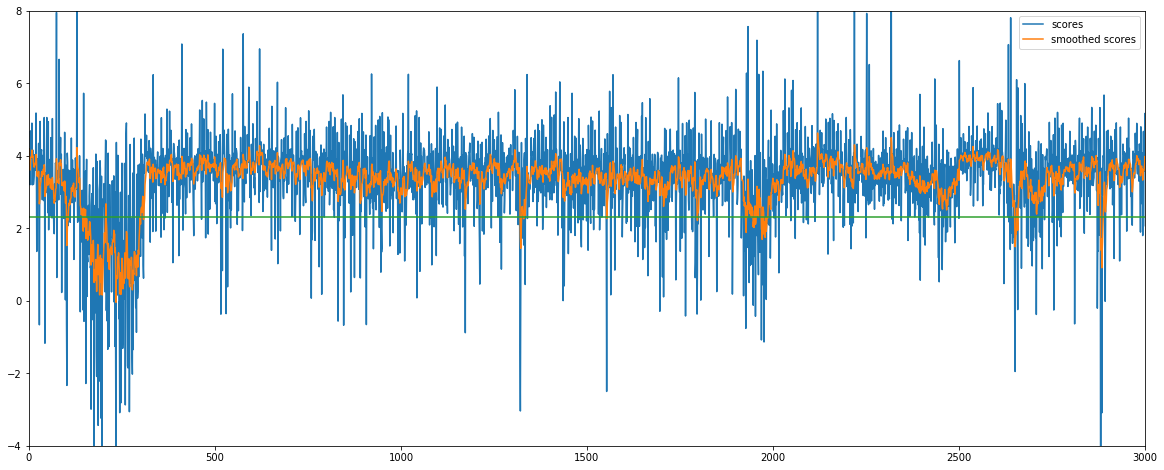

In [51]:
L = len(scores.reshape(-1))
plt.figure(figsize=(20,8))
plt.plot(np.arange(L), scores.reshape(-1), '-', label='scores', alpha=1)
plt.plot(np.arange(L), smoothed_scores.reshape(-1), '-', label='smoothed scores')
plt.plot([0, 5000], [treshold, treshold])
plt.xlim([0,3000])
plt.ylim([-4,8])
plt.legend()
plt.show()

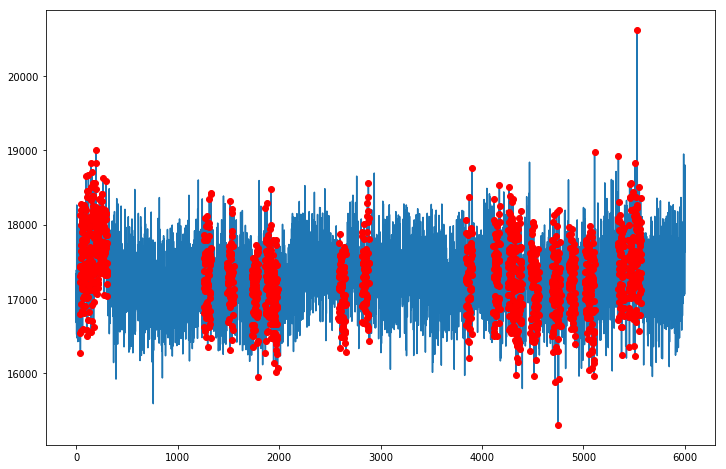

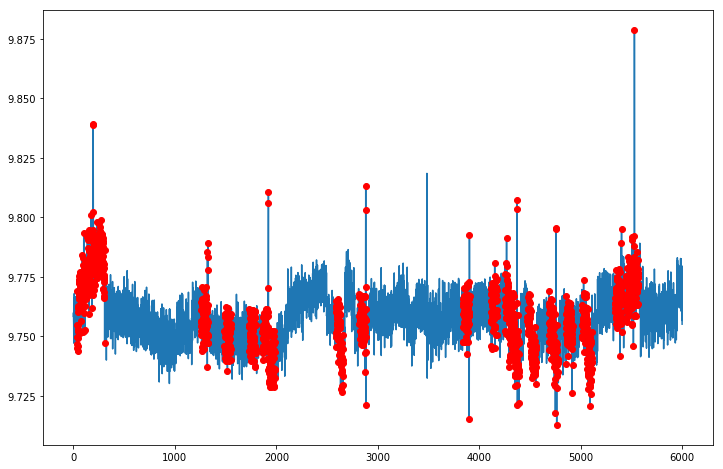

test----------------------------train
diff (0.56805839522235591, 0.62590221226472054)
None
CPU times: user 495 ms, sys: 33 ms, total: 528 ms
Wall time: 539 ms


In [33]:
%%time
# 1 hour predictions
utils.plot_with_target(dropped_origin, targets)
utils.plot_with_target(df['trend'].values, targets)
print(get_log_reg_score(targets))

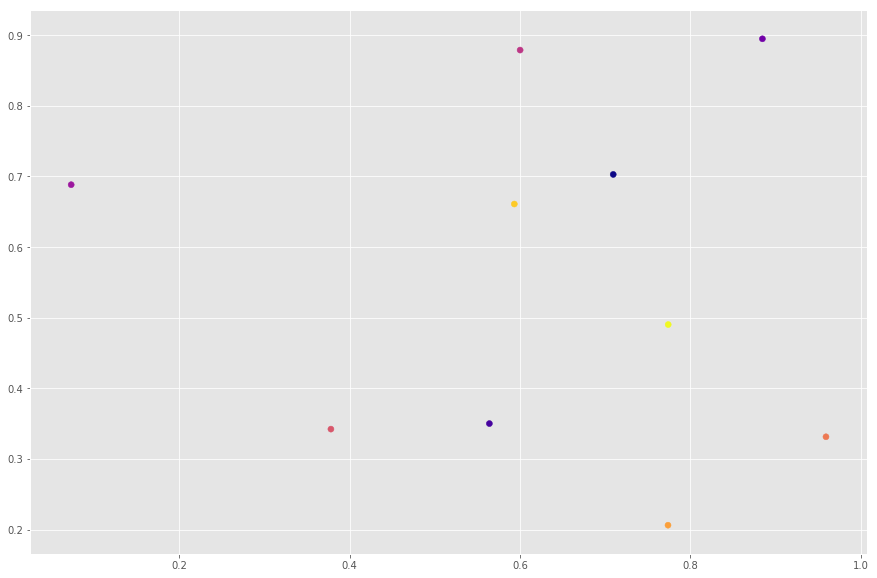

In [148]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

plt.figure(figsize=(15,10))
x = np.random.random(10)
y = np.random.random(10)

colors = cm.plasma(np.linspace(0, 1, len(y)))
plt.scatter(x, y, color=colors)
plt.show()

In [242]:
def plot_targets(series, y_true, y_pred):
    true_index = set()
    plt.style.use('ggplot')
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(len(series)), series)
    for i, y in enumerate(y_true):
        if y > 0:
            true_index.add(i)
    false_index = set(np.arange(len(series))) - true_index
    series_true = [x for i, x in enumerate(series) if i in true_index]
    series_false = [x for i, x in enumerate(series) if i in false_index]
    
    y_pred_true = [y for i, y in enumerate(y_pred) if i in true_index]
    y_pred_false = [y for i, y in enumerate(y_pred) if i in false_index]
    cmap = plt.cm.get_cmap('seismic')
    sc = plt.scatter(sorted(true_index), series_true, c=1 - np.array(y_pred_true),
                cmap = cmap, edgecolors='red', linewidth=5,s=500)
    plt.scatter(sorted(false_index), series_false, c=1 - np.array(y_pred_false), 
                cmap=cmap,s=500)
    plt.colorbar(sc)
    plt.show()

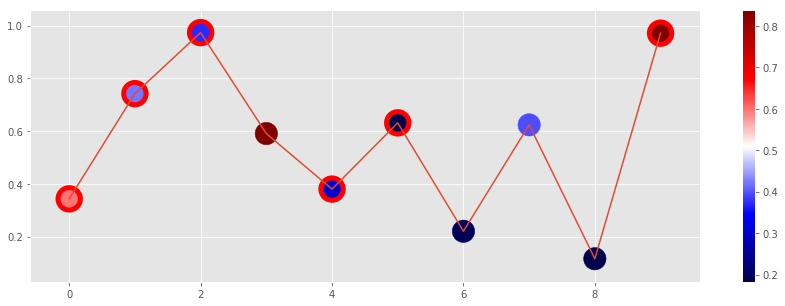

In [243]:
plot_targets(np.random.random(10), [1,1,1,0,1,1,0,0,0,1], np.random.random(10))

In [114]:
%%time
# 1 hour predictions
targets = utils.get_targets_with_mixture(df[['trend']],horizont=6 * 11,top=0.005)
utils.plot_with_target(dropped_origin, targets)
utils.plot_with_target(df['trend'].values, targets)
print(get_log_reg_score(targets))

TypeError: get_targets_with_mixture() missing 1 required positional argument: 'halflife'

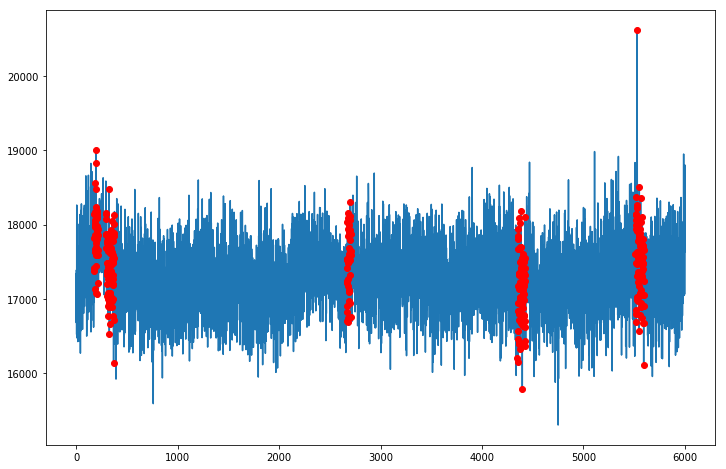

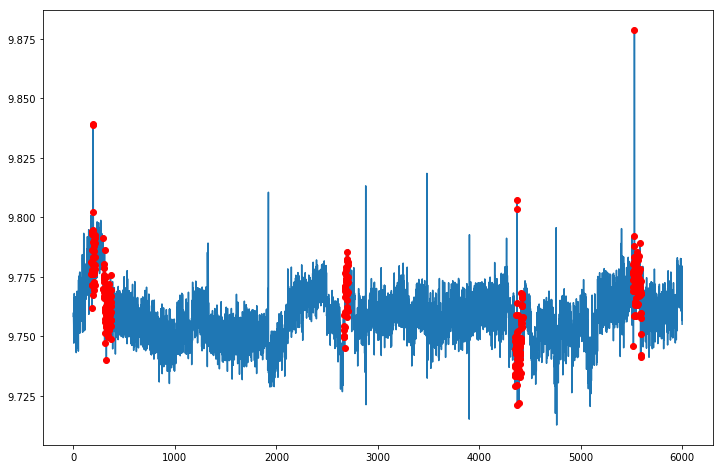

test----------------------------train
diff (0.53660053743821123, 0.66103371286274026)
None
CPU times: user 879 ms, sys: 25.6 ms, total: 905 ms
Wall time: 909 ms


In [60]:
%%time
df[['trend']].shape
dropped_origin.shape
targets = ewma.get_target_future(df[['trend']],horizont=6*11, top=0.1, halflife=50)
utils.plot_with_target(dropped_origin, targets)
utils.plot_with_target(df['trend'].values, targets)
print(get_log_reg_score(targets))

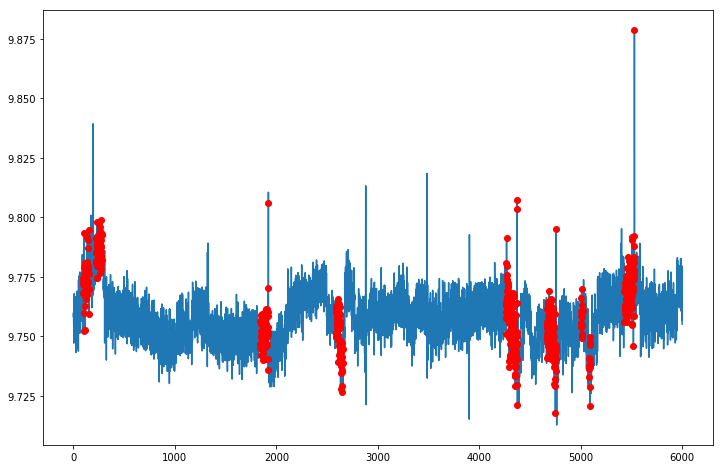

test----------------------------train
diff (0.68681050970467827, 0.69311153689426608)
None


In [78]:
values = df['trend'].values
targets = ewma.get_ma_target(df,window=50)
utils.plot_with_target(values, target)
print(get_log_reg_score(targets))

# End to end

### Efficiency

Reading data from "data/eff_train/eff_train1.csv"...
TSA decomposition...

/Users/alex/Desktop/GlobalChangersSibur/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/alex/anaconda/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converged. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)



lag_to_drop 70
Start probabilities memorization

100%|██████████| 1/1 [00:06<00:00,  6.35s/it]
/Users/alex/Desktop/GlobalChangersSibur/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,com=9,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


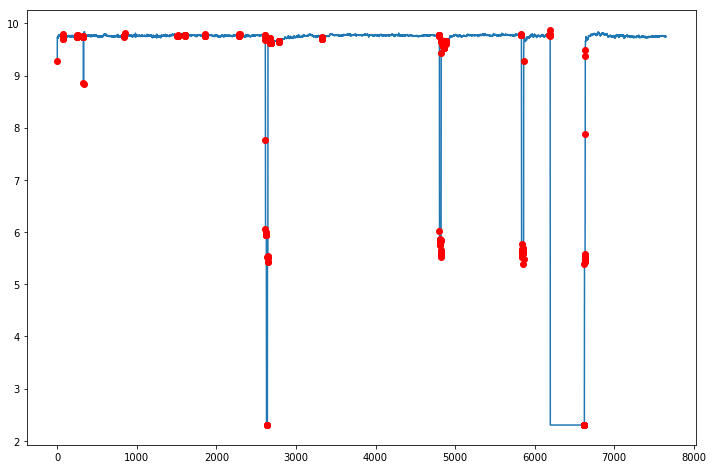

test---------------------------train
(0.6148325590398761, 0.75392076236339445)
CPU times: user 55.5 s, sys: 1.21 s, total: 56.7 s
Wall time: 56.2 s


In [45]:
%%time 
score = utils.end_to_end('data/eff_train/eff_train1.csv',plot=True)
print('test---------------------------train')
print(score)

Reading data from "data/qual_train/qual_train1.csv"...
0.195720597078


/Users/alex/Desktop/GlobalChangersSibur/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


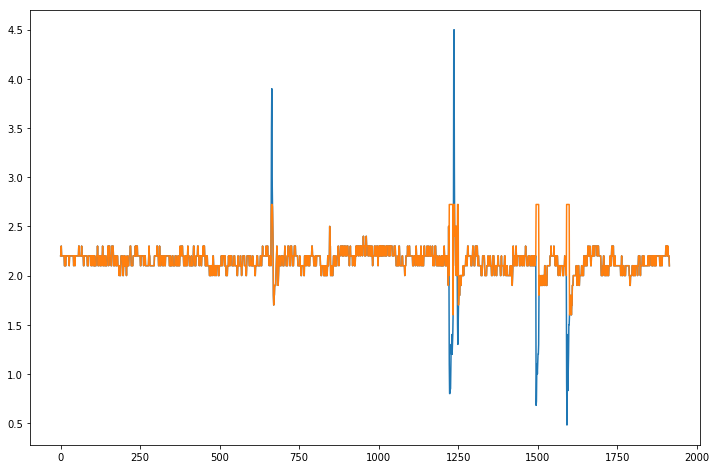

TSA decomposition...
lag_to_drop 1
Start probabilities memorization

100%|██████████| 1/1 [00:03<00:00,  3.11s/it]
/Users/alex/Desktop/GlobalChangersSibur/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,com=4,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


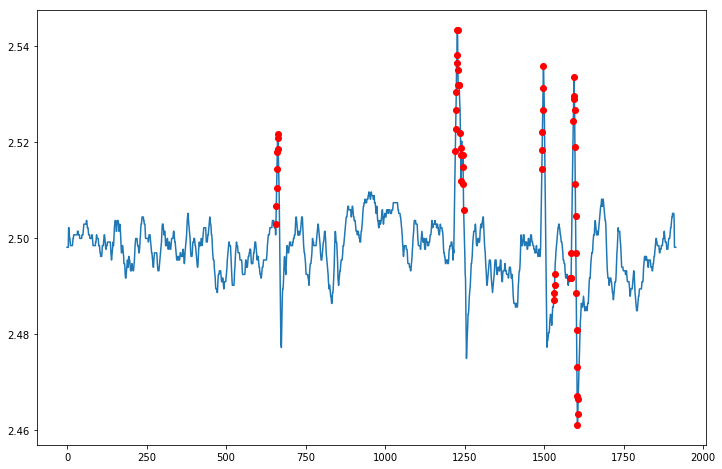

test---------------------------train
(0.33273676360924687, 0.11750000000000001)


In [46]:
score = utils.end_to_end('data/qual_train/qual_train1.csv',clip_treshold=None,plot=True,lag_to_drop=1,horizont=4,X_length=10,top=0.01)
print('test---------------------------train')
print(score)

Reading data from "data/energy_cons_train/Energy_cons_train1.csv"...
2.8025260613


/Users/alex/Desktop/GlobalChangersSibur/utils.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return df


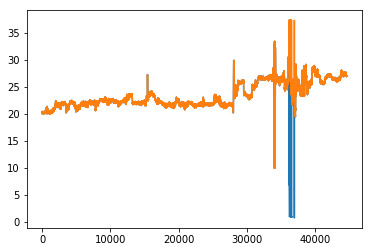

TSA decomposition...
lag_to_drop 20
Start probabilities memorization

100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
/Users/alex/Desktop/GlobalChangersSibur/gaussian_mixture_anomaly_detection.py:197: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(min_periods=0,com=6,adjust=True,ignore_na=False).mean()
  return np.array([np.array(pd.ewma(series, halflife)).reshape(-1) for series in frames])


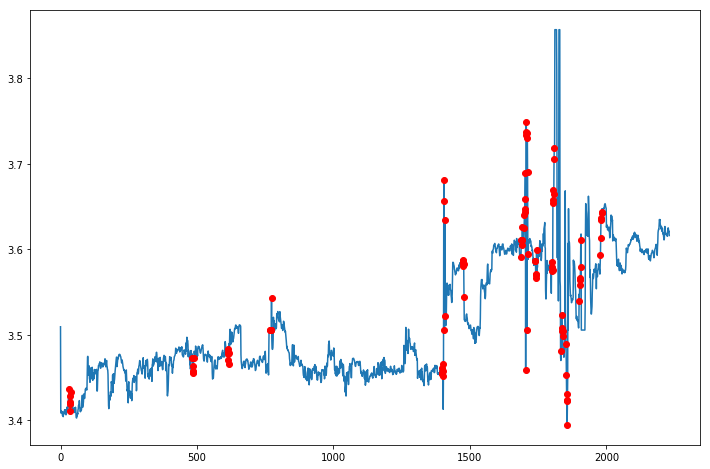

train---------------------------test
(0.48552606813476379, 0.64402412779242824)


In [40]:
score = utils.end_to_end('data/energy_cons_train/Energy_cons_train1.csv',
                         plot=True,
                         lag_to_drop=20,
                         horizont=2*60,
                         X_length=80,
                         top=0.01)
print('train---------------------------test')
print(score)